In [13]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_trajectory, plot_compare, plot_errors, plot_time_kinetic_energy
from plasma import cyclotron_xy, ExB_xy

## Boris Push and Main Loop

In [14]:
def null_E_field(x, t):
    return np.array([0.0, 0.0, 0.0])

def Ey0(x, t) :
    return np.array([0.0, 1.0, 0.0])

def Bz0(x, t):
    return np.array([0.0, 0.0, 1.0])

In [15]:
def boris_push(x, t, v, q, m, dt, electric_field, magnetic_field):
    """
    Advance velocity v by one full step using Boris scheme.
    x: position at half step (x_{n+1/2})
    t: time at half step (t_{n+1/2})
    v: velocity at time step n
    q, m: charge and mass
    dt: timestep
    """

    E = electric_field(x, t)
    B = magnetic_field(x, t)

    # Half acceleration by E
    v_minus = v + (q * dt / (2 * m)) * E

    # Rotation by B
    t_vec = (q * dt / (2 * m)) * B
    t_mag2 = np.dot(t_vec, t_vec)
    s_vec = 2 * t_vec / (1 + t_mag2)

    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)

    # Second half acceleration by E
    v_new = v_plus + (q * dt / (2 * m)) * E

    return v_new

In [16]:
def simulate(x0, v0, q, m, dt, nsteps, electric_field, magnetic_field):
    """
    Simulate a particle trajectory using the Boris scheme.
    Returns arrays of x and v.
    """
    # Initializations
    x_half = x0 + 0.5 * dt * v0   # Leapfrog staggering
    v = v0.copy()

    # Storage
    xs = [x_half]
    vs = [v0]

    for n in range(nsteps):
        # Velocity update (Boris)
        v = boris_push(x_half, (n + 1/2) * dt, v, q, m, dt, electric_field, magnetic_field)

        # Position update
        x_half = x_half + v * dt

        # Store
        xs.append(x_half.copy())
        vs.append(v.copy())

    return np.array(xs), np.array(vs)


# Physical Parameters

In [17]:
q = -1.0
m = 1.0
B0 = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 11
nsteps = int(NT*T/dt)
times = np.arange(0, NT*T, dt) + dt/2

x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

# Cyclotron Motion

In [18]:
x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, dt, nsteps, null_E_field, Bz0)

x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times)

## Trajectories

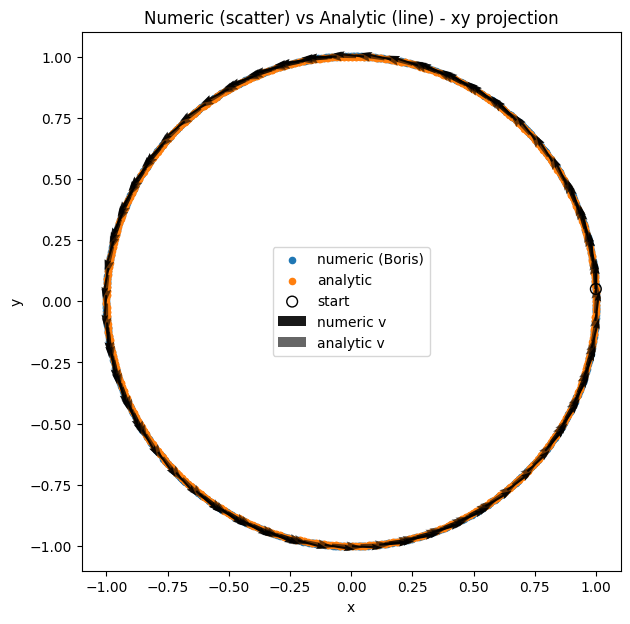

In [19]:
plot_compare(x_cyc_num, v_cyc_num, x_cyc_an, v_cyc_an, step=8, show_arrows=True)

## Kinetic energies

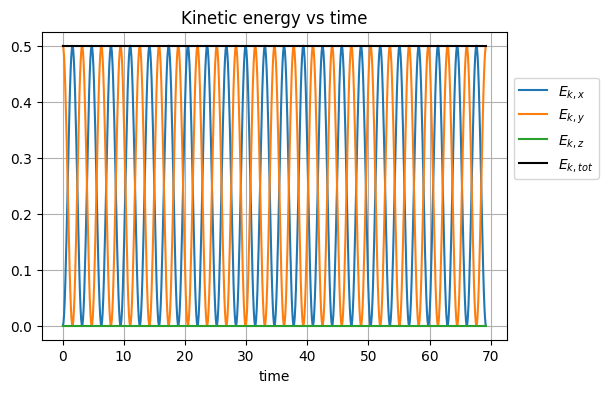

In [20]:
plot_time_kinetic_energy(times, m, v_cyc_num)

# ExB drift

In [21]:
x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, dt, nsteps, Ey0, Bz0)

x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times)

## Trajectories

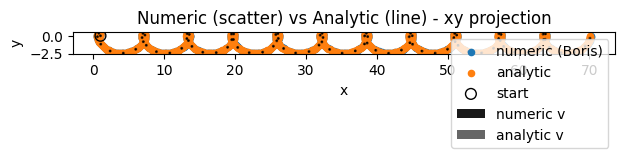

In [22]:
plot_compare(x_ExB_num, v_ExB_num, x_ExB_an, v_ExB_an, step=8, show_arrows=True)

# Errors

## Error in time

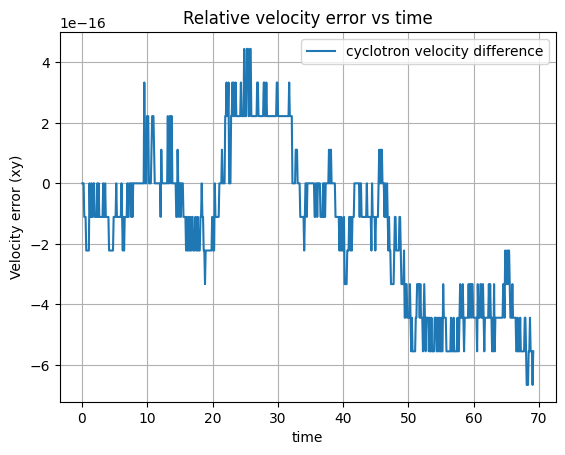

In [26]:
v_cyc_norm_num = np.linalg.norm(v_cyc_num, axis=1)
v_cyc_norm_an = np.linalg.norm(v_cyc_an, axis=1)

diff_v_cyc_norm = v_cyc_norm_num - v_cyc_norm_an


diff_x_cyc = (x_cyc_num[:, :2] - x_cyc_an[:, :2])
diff_x_ExB = (x_ExB_num[:, :2] - x_ExB_an[:, :2])
errs_x_cyc = np.sqrt(np.sum(diff_x_cyc**2, axis=1))
errs_x_ExB = np.sqrt(np.sum(diff_x_ExB**2, axis=1))

diff_v_cyc = (np.linalg.norm(v_cyc_num, axis=1)[:, None] - np.linalg.norm(v_cyc_an, axis=1)[:, None]) / np.linalg.norm(v_cyc_num, axis=1)[:, None]
diff_v_ExB = (np.linalg.norm(v_ExB_num, axis=1)[:, None] - np.linalg.norm(v_ExB_num, axis=1)[:, None]) / np.linalg.norm(v_ExB_num, axis=1)[:, None]
errs_v_cyc = np.sqrt(np.sum(diff_v_cyc**2, axis=1))
errs_v_ExB = np.sqrt(np.sum(diff_v_ExB**2, axis=1))

# plt.figure()
# plt.grid()
# plt.plot(times, errs_x_cyc, label='cyclotron')
# plt.plot(times, errs_x_ExB, label='ExB')
# plt.xlabel('time')
# plt.ylabel('position error (xy)')
# plt.title('Absolute Positional error vs time')
# plt.legend()
# plt.show()

plt.figure()
plt.grid()
plt.plot(times, diff_v_cyc_norm, label='cyclotron velocity difference')
# plt.semilogy(times,np.linalg.norm(v_ExB_num, axis=1), label='ExB')
plt.xlabel('time')
plt.ylabel('Velocity error (xy)')
plt.title('Relative velocity error vs time')
plt.legend()
plt.show()